# Classification modeling
---

Working with interpolated data!!!

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import random

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, plot_confusion_matrix, classification_report, plot_roc_curve
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text

random.seed(42)

---
### Load the data

In [2]:
df = pd.read_csv('../../coastal_upwelling_output/interpolated.csv')
df.rename({'Unnamed: 0':'time'},inplace=True, axis=1)
# df.set_index('time', inplace=True)
df

,time,10,16,22,28,34,40,46,52,58,...,154,160,166,172,178,184,190,196,CUTI,upwelling
0,2018-07-17 17:02:10.061576192,14.050275,11.959311,10.073221,9.767676,9.482159,9.105380,9.056556,9.055258,9.038180,...,7.528777,7.338059,7.275881,7.237259,7.168897,7.087552,7.032359,6.999018,0.978,1
1,2018-07-17 18:25:30.061576192,13.957127,10.870573,9.901940,9.695652,9.342295,9.117574,9.069495,9.021141,9.080058,...,7.655243,7.505627,7.412475,7.401960,7.334573,7.211357,7.136497,7.066432,0.978,1
2,2018-07-17 19:48:50.061576192,14.042208,10.949701,9.850174,9.776190,9.300516,9.257225,9.193214,9.130008,9.150563,...,7.664953,7.591927,7.506104,7.450694,7.371207,7.261236,7.173726,7.114324,0.978,1
3,2018-07-17 21:12:10.061576192,14.140387,11.095460,9.932039,9.728931,9.258736,9.346245,9.331689,9.174076,9.217667,...,7.672826,7.621918,7.514516,7.366019,7.300821,7.201451,7.165526,7.150486,0.978,1
4,2018-07-17 22:35:30.061576192,14.116346,11.205226,9.967389,9.708485,9.617728,9.247863,9.456468,9.246932,9.266785,...,7.710273,7.659872,7.586809,7.503011,7.421469,7.306080,7.253350,7.191860,0.978,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2784,2018-12-25 19:42:10.061576192,11.958360,11.958135,11.958165,11.952446,11.940669,11.822778,11.618385,11.532611,11.528637,...,9.168857,9.034012,8.862957,8.840823,8.886654,8.814835,8.724564,8.534272,0.171,1
2785,2018-12-25 21:05:30.061576192,11.966183,11.966942,11.967257,11.958619,11.929104,11.848490,11.649076,11.534315,11.527931,...,9.089054,9.022601,8.882834,8.855709,8.847703,8.814844,8.684697,8.536650,0.171,1
2786,2018-12-25 22:28:50.061576192,11.974130,11.973730,11.974008,11.968621,11.933196,11.913816,11.740736,11.675417,11.565127,...,9.166364,9.116368,9.001082,8.974241,8.897539,8.833432,8.750648,8.539029,0.171,1
2787,2018-12-25 23:52:10.061576192,11.982202,11.979041,11.978485,11.968747,11.949102,11.948089,11.841979,11.765422,11.649837,...,9.212205,9.163474,9.088436,9.043842,8.930959,8.866600,8.816795,8.541407,0.171,1


In [3]:
df['upwelling'].value_counts(normalize=True)

1    0.604159
0    0.395841
Name: upwelling, dtype: float64

In [4]:
df.isna().sum()

time         0
10           0
16           0
22           0
28           0
34           0
40           0
46           0
52           0
58           0
64           0
70           0
76           0
82           0
88           0
94           0
100          0
106          0
112          0
118          0
124          0
130          0
136          0
142          0
148          0
154          0
160          0
166          0
172          0
178          0
184          0
190          0
196          0
CUTI         0
upwelling    0
dtype: int64

---
### Checking feature correlation

One of the big assumptions we make when building logistic regression models is that our independent features are independent of each other. We can print out a heatmap to check whether our features are correlated to each other or not.

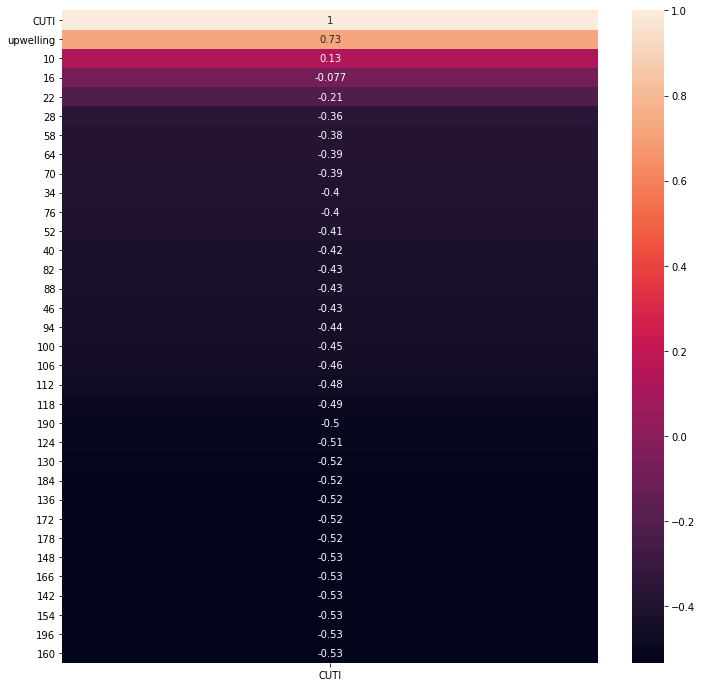

In [5]:
plt.figure(figsize=(12,12))
sns.heatmap(df.corr()[['CUTI']].sort_values(by='CUTI', ascending=False),
           annot=True);

Are the deeper depths correlated here because they change so little?

---
### Modeling iteration 1 

In [7]:
X = df.drop(columns=['upwelling', 'time', 'CUTI'])
y = df['upwelling']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [8]:
pipe = Pipeline([
    ('sc', StandardScaler()),
    ('logreg', LogisticRegression(max_iter=1000, solver='liblinear'))
])

pipe_params = {
    'logreg__penalty':['l1', 'l2'],
    'logreg__C': np.linspace(0.001, 1, 10)
}

gs_lr = GridSearchCV(pipe, pipe_params, cv=5, verbose=1, return_train_score=True)

gs_lr.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('sc', StandardScaler()),
                                       ('logreg',
                                        LogisticRegression(max_iter=1000,
                                                           solver='liblinear'))]),
             param_grid={'logreg__C': array([0.001, 0.112, 0.223, 0.334, 0.445, 0.556, 0.667, 0.778, 0.889,
       1.   ]),
                         'logreg__penalty': ['l1', 'l2']},
             return_train_score=True, verbose=1)

In [9]:
print(f'Best parameters: {gs_lr.best_params_}')
print(f'Best score: {gs_lr.best_score_}')

Best parameters: {'logreg__C': 0.778, 'logreg__penalty': 'l2'}
Best score: 0.7508227609596785


Now that we have the best parameters, we can create a logistic regression model with these parameters and see what the coefficients are for our poly features.

In [10]:
print(gs_lr.cv_results_['mean_train_score'].mean())
print(gs_lr.cv_results_['mean_test_score'].mean())

0.7277308691088694
0.7242102979296798


In [11]:
print(f'Train accuracy: {gs_lr.score(X_train, y_train)}')
print(f'Test accuracy: {gs_lr.score(X_test, y_test)}')

Train accuracy: 0.7522716403634625
Test accuracy: 0.7636103151862464


Question to self: do the coefficients need to be exponentiated to get their actual values, since the logistic regression model uses the logit function to transform the data?

In [12]:
gs_lr.predict(X_train)

array([1, 1, 0, ..., 1, 1, 1], dtype=int64)

In [13]:
gs_lr.best_estimator_['logreg'].coef_

array([[-0.2904795 , -0.49005886,  0.55056012, -0.41192991, -0.00567119,
         0.45011401, -0.79188916,  0.19524354, -0.15447718,  0.59159265,
         0.38643626,  0.39541785, -2.52220924,  1.17262818, -0.54600158,
         0.7083437 ,  0.9914584 , -0.93531045, -0.35682267, -0.45047278,
         0.62895776,  0.26299382, -0.61208823,  0.49824669, -0.16973578,
        -0.7592386 ,  0.66827188,  0.15606952, -0.02338226, -1.12488252,
         1.06519774, -1.100485  ]])

In [14]:
coefs = gs_lr.best_estimator_['logreg'].coef_[0]
coefs = np.exp(coefs)

In [15]:
sorted(list(zip(X.columns, coefs)), key=lambda x: x[1], reverse=True)

[('88', 3.2304717684744655),
 ('190', 2.9014126395591804),
 ('106', 2.6951622434856946),
 ('100', 2.0306251507073076),
 ('166', 1.9508630740785673),
 ('130', 1.8756546807859056),
 ('64', 1.80686383522844),
 ('22', 1.7342241265362868),
 ('148', 1.6458330911724413),
 ('40', 1.5684909912279255),
 ('76', 1.4850045699036711),
 ('70', 1.4717265837494955),
 ('136', 1.300818679344952),
 ('52', 1.2156069936144376),
 ('172', 1.1689074629395528),
 ('34', 0.9943448616495835),
 ('178', 0.9768889877875252),
 ('58', 0.8568630438096194),
 ('154', 0.8438877619873901),
 ('10', 0.7479048627469902),
 ('118', 0.6998965974772171),
 ('28', 0.6623707008510613),
 ('124', 0.6373267676614214),
 ('16', 0.612590334861399),
 ('94', 0.5792613142198471),
 ('142', 0.5422174097690512),
 ('160', 0.468022645514777),
 ('46', 0.45298821768081254),
 ('112', 0.392464006972515),
 ('196', 0.3327096791645972),
 ('184', 0.3246906085583557),
 ('82', 0.0802820484818942)]

In [16]:
gs_lr_train_preds = gs_lr.predict(X_train)
gs_lr_test_preds = gs_lr.predict(X_test)

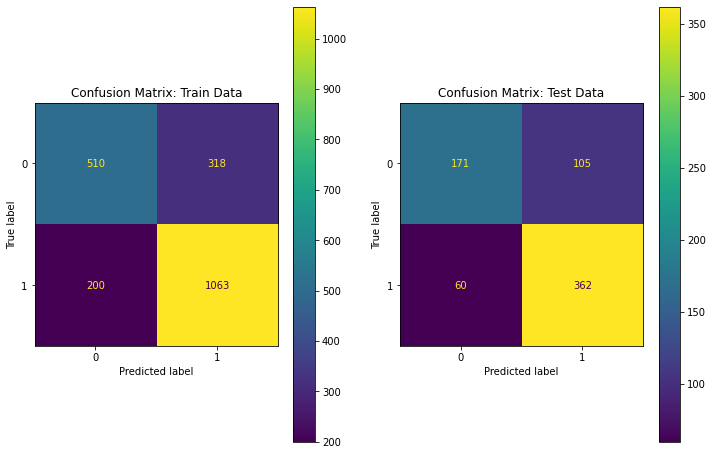

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

cm = confusion_matrix(y_train, gs_lr_train_preds)
ConfusionMatrixDisplay(cm).plot(ax=ax1)
ax1.set_title('Confusion Matrix: Train Data')

cm = confusion_matrix(y_test, gs_lr_test_preds)
ConfusionMatrixDisplay(cm).plot(ax=ax2)
ax2.set_title('Confusion Matrix: Test Data');

Looks like our false negatives outnumber our false positives

In [18]:
print(classification_report(y_test, gs_lr_test_preds))

              precision    recall  f1-score   support

           0       0.74      0.62      0.67       276
           1       0.78      0.86      0.81       422

    accuracy                           0.76       698
   macro avg       0.76      0.74      0.74       698
weighted avg       0.76      0.76      0.76       698



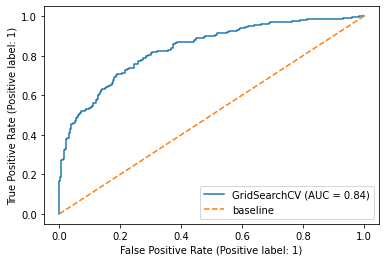

In [19]:
# ROC curve
plot_roc_curve(gs_lr, X_test, y_test)

# add worst case scenario line
plt.plot([0,1],[0,1], label='baseline', linestyle='--')

# add a legend
plt.legend();
# want AUC (area under curve) to be as close to 1 as possible

#### Explore misclassified data

In [ ]:
# Get indices of misclassified data source: https://stackoverflow.com/questions/25551977/retrieve-misclassified-documents-using-scikitlearn
misclass_ind_lr = np.where(y_test != gs_lr_test_preds)
misclass_ind_lr

In [ ]:
X_test

In [ ]:
df

In [ ]:
df.iloc[X_test.index]['time']

In [ ]:
X_test_times = df.iloc[X_test.index]['time']

In [ ]:
X_test_times.iloc[misclass_ind_lr]

In [ ]:
pd.DataFrame(X_test_times.iloc[misclass_ind_lr]).reset_index(drop=True)

In [ ]:
frames_lr = [pd.DataFrame(X_test_times.iloc[misclass_ind_lr]), X_test.iloc[misclass_ind_lr], pd.DataFrame(y_test.iloc[misclass_ind_lr])]
misclass_df_lr = pd.concat(frames_lr, axis=1)

In [ ]:
misclass_df_lr

---
### Decision tree classifiers
Decision trees come in a lot of different shapes, so it'd be best to use GridSearchCV to find the best parameters for a tree for upwelling classification.

In [20]:
X = df.drop(columns=['time', 'upwelling', 'CUTI'])
y = df['upwelling']

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [22]:
param_grid = {
    'max_depth': [5, 7, 9],
    'min_samples_split': [5, 10, 15, 20],
    'min_samples_leaf': [2, 3, 4, 5, 6],
    'ccp_alpha': [0, 0.01, 0.1, 1, 10]
}

gs_dt = GridSearchCV(estimator=DecisionTreeClassifier(),
                 param_grid=param_grid,
                 verbose=1,
                 cv=5)

%time gs_dt.fit(X_train, y_train)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits
Wall time: 35 s


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'ccp_alpha': [0, 0.01, 0.1, 1, 10],
                         'max_depth': [5, 7, 9],
                         'min_samples_leaf': [2, 3, 4, 5, 6],
                         'min_samples_split': [5, 10, 15, 20]},
             verbose=1)

In [23]:
gs_dt.best_estimator_

DecisionTreeClassifier(ccp_alpha=0, max_depth=9, min_samples_leaf=2,
                       min_samples_split=5)

In [24]:
print(f'Score on training set: {gs_dt.score(X_train, y_train)}')
print(f'Score on testing set: {gs_dt.score(X_test, y_test)}')

Score on training set: 0.9225251076040172
Score on testing set: 0.9011461318051576


In [25]:
gs_dt_train_preds = gs_dt.predict(X_train)
gs_dt_test_preds = gs_dt.predict(X_test)

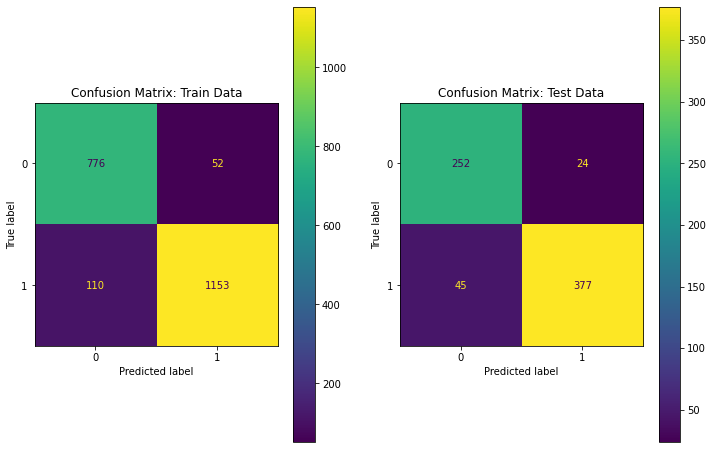

In [26]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

cm = confusion_matrix(y_train, gs_dt_train_preds)
ConfusionMatrixDisplay(cm).plot(ax=ax1)
ax1.set_title('Confusion Matrix: Train Data')

cm = confusion_matrix(y_test, gs_dt_test_preds)
ConfusionMatrixDisplay(cm).plot(ax=ax2)
ax2.set_title('Confusion Matrix: Test Data');

In [27]:
sorted(list(zip(X_train.columns, gs_dt.best_estimator_.feature_importances_)), key=lambda x: x[1], reverse=True)

[('136', 0.3069907489881999),
 ('196', 0.12537867245982157),
 ('10', 0.12020451869017106),
 ('40', 0.08494424691958449),
 ('22', 0.04379782865388964),
 ('16', 0.04044966734175523),
 ('34', 0.04014442522812701),
 ('88', 0.040133793249793714),
 ('166', 0.03174148026462565),
 ('112', 0.024087075155185232),
 ('52', 0.02337422369131087),
 ('190', 0.018997880906966552),
 ('148', 0.018015582003933064),
 ('124', 0.015630917215948763),
 ('82', 0.01509111135533313),
 ('58', 0.011583112055151931),
 ('94', 0.010858454262513549),
 ('130', 0.008463362678787254),
 ('76', 0.00794014620063439),
 ('28', 0.004590144306302188),
 ('178', 0.0020490741017431886),
 ('64', 0.0012196869653233247),
 ('142', 0.00121550373817246),
 ('160', 0.00119112844125722),
 ('46', 0.0011558879548294924),
 ('154', 0.0007513271706391686),
 ('70', 0.0),
 ('100', 0.0),
 ('106', 0.0),
 ('118', 0.0),
 ('172', 0.0),
 ('184', 0.0)]

In [155]:
print(gs_dt.best_estimator_.feature_importances_)
list(X_train.columns)

[0.08962788 0.07425705 0.04100082 0.00037778 0.03708134 0.08870887
 0.         0.01872028 0.01318622 0.         0.         0.00122053
 0.00324227 0.05325216 0.         0.         0.         0.02515459
 0.01890459 0.         0.0041774  0.32093152 0.         0.01783323
 0.         0.01286951 0.02318473 0.         0.         0.00659374
 0.01896804 0.13070743]


['10',
 '16',
 '22',
 '28',
 '34',
 '40',
 '46',
 '52',
 '58',
 '64',
 '70',
 '76',
 '82',
 '88',
 '94',
 '100',
 '106',
 '112',
 '118',
 '124',
 '130',
 '136',
 '142',
 '148',
 '154',
 '160',
 '166',
 '172',
 '178',
 '184',
 '190',
 '196']

We saw that `seawater_temperature` was the most strongly correlated feature to upwelling, but `sea_surface_temperature` ended up having the greatest feature importance. I want to trust the model on this, but I'm wondering why this happened. 

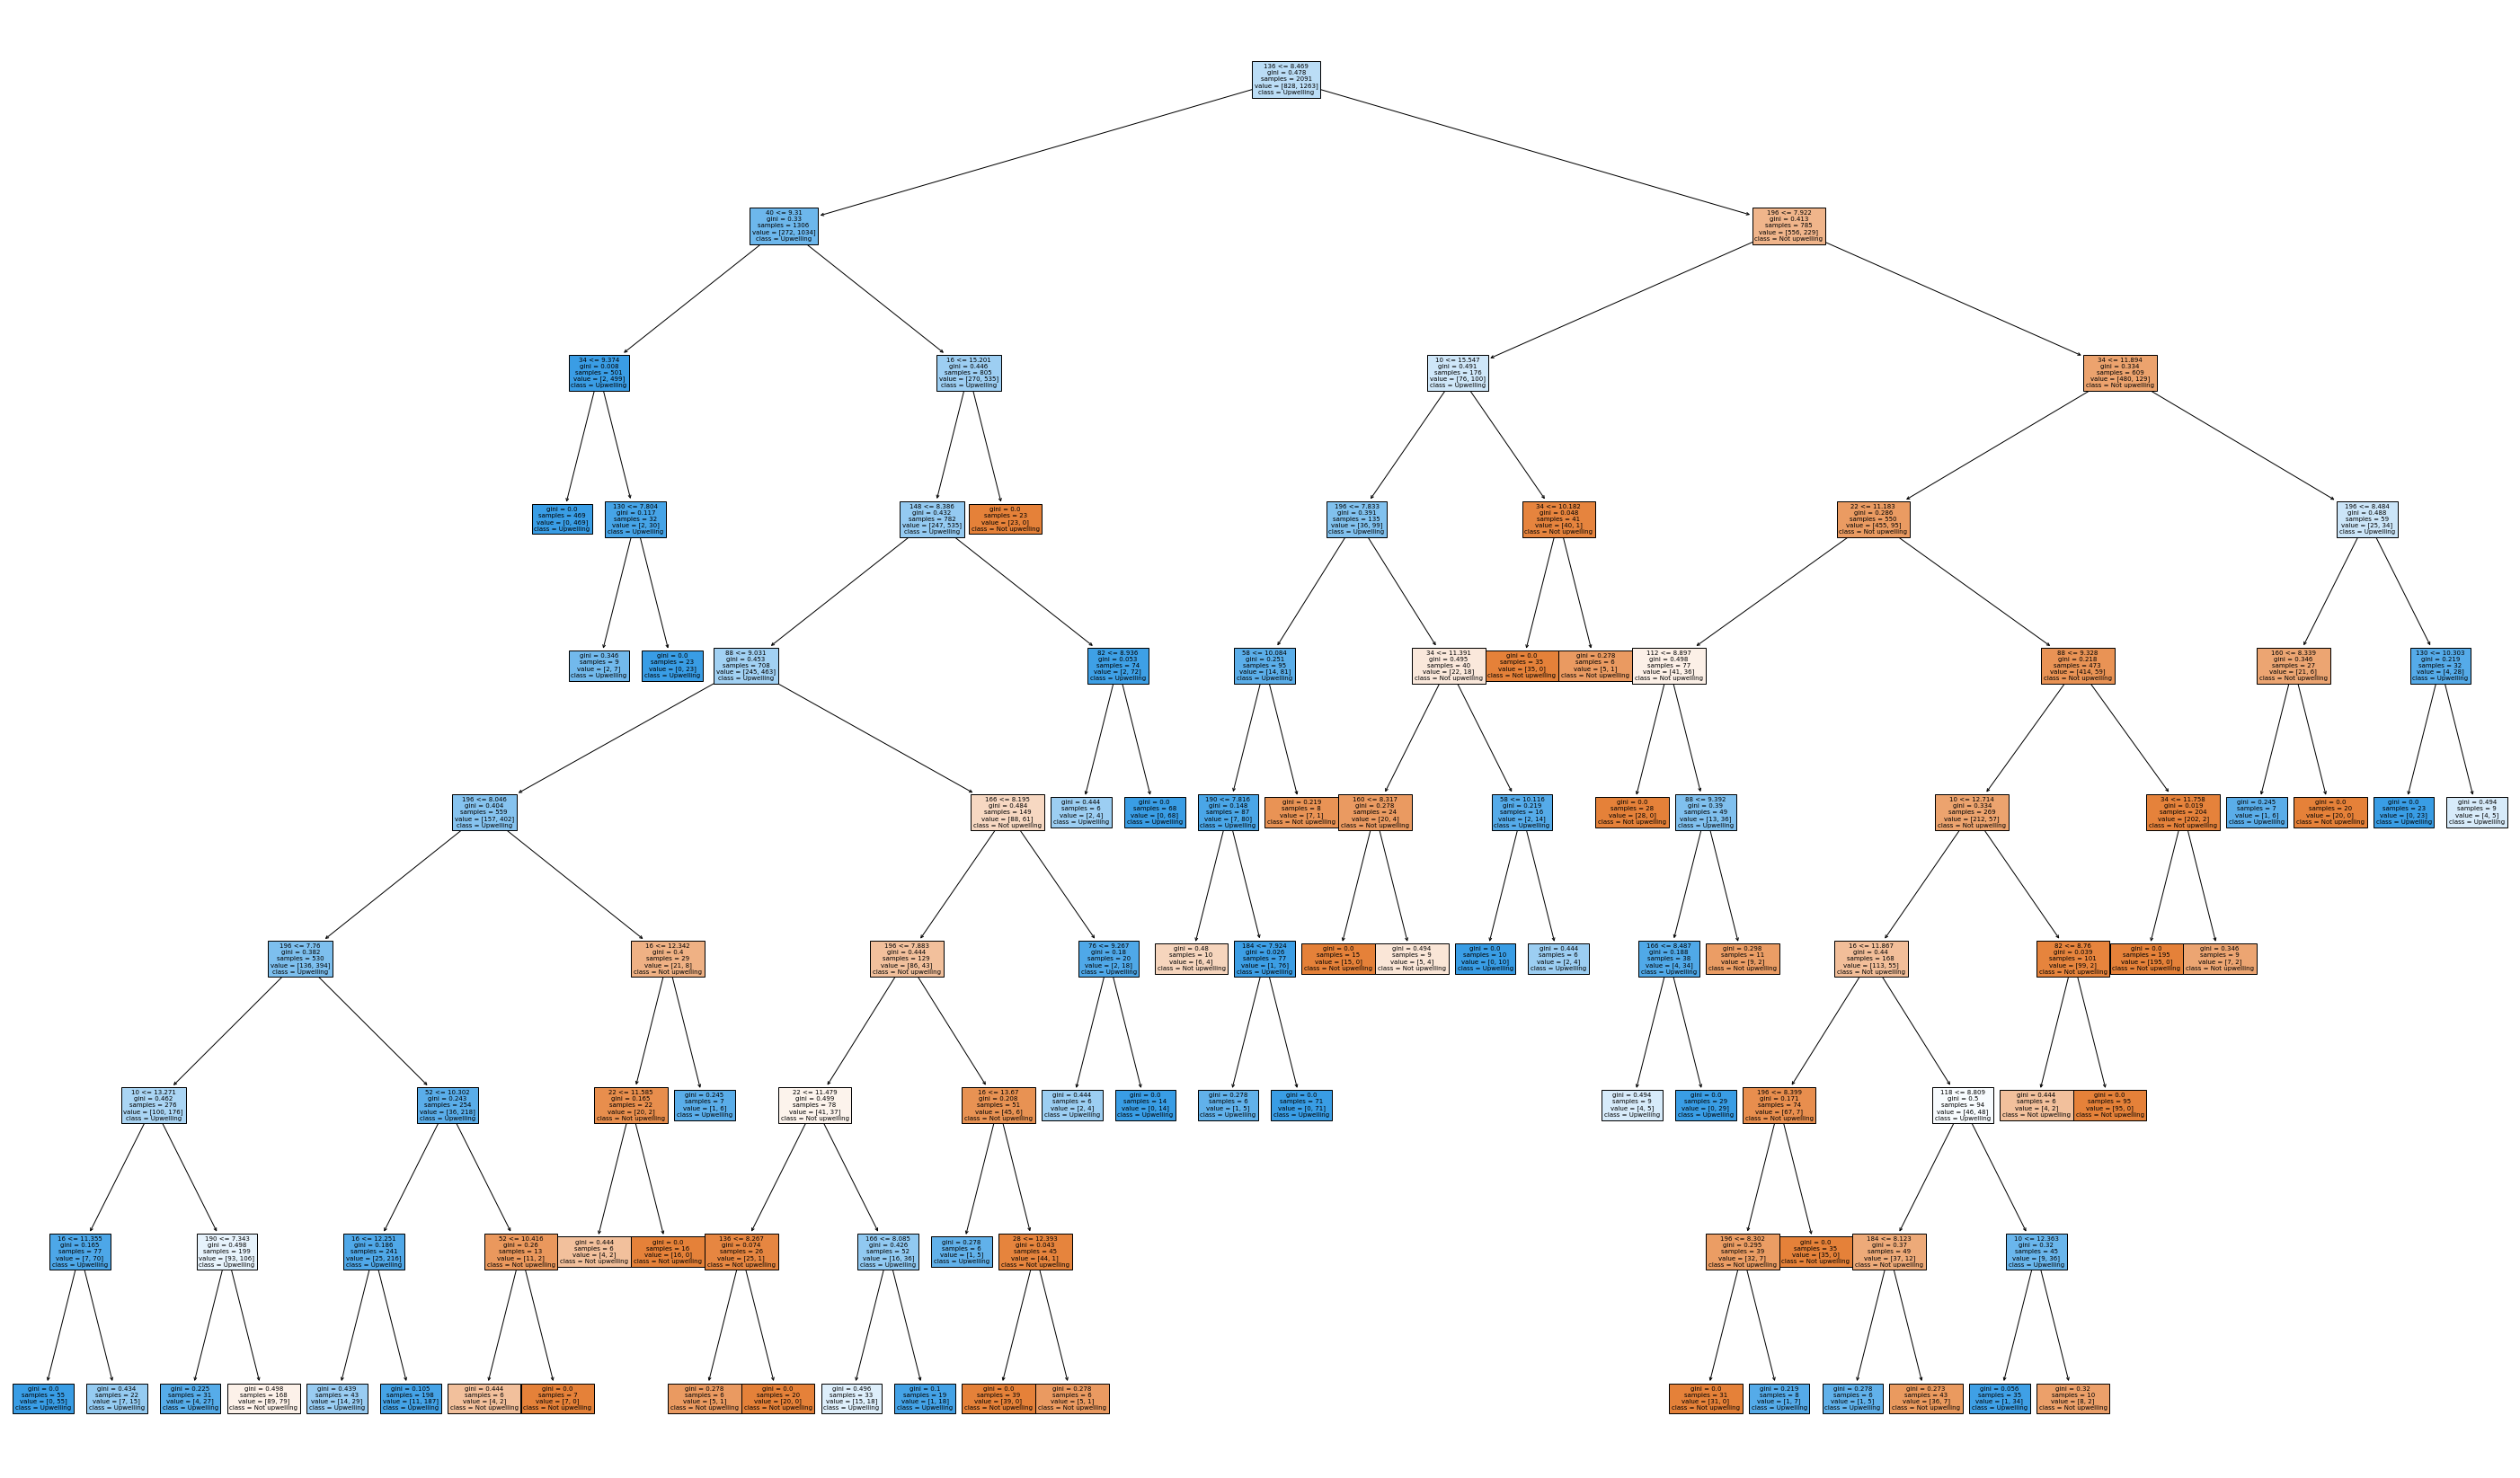

In [156]:
# Establish size of figure.
plt.figure(figsize = (50, 30))

# Plot our tree.
plot_tree(gs_dt.best_estimator_,
          feature_names = X_train.columns,
          class_names = ['Not upwelling', 'Upwelling'],
          filled = True);

In [157]:
print(export_text(gs_dt.best_estimator_,
                  list(X_train.columns)));

|--- 136 <= 8.47
|   |--- 40 <= 9.31
|   |   |--- 34 <= 9.37
|   |   |   |--- class: 1
|   |   |--- 34 >  9.37
|   |   |   |--- 130 <= 7.80
|   |   |   |   |--- class: 1
|   |   |   |--- 130 >  7.80
|   |   |   |   |--- class: 1
|   |--- 40 >  9.31
|   |   |--- 16 <= 15.20
|   |   |   |--- 148 <= 8.39
|   |   |   |   |--- 88 <= 9.03
|   |   |   |   |   |--- 196 <= 8.05
|   |   |   |   |   |   |--- 196 <= 7.76
|   |   |   |   |   |   |   |--- 10 <= 13.27
|   |   |   |   |   |   |   |   |--- 16 <= 11.36
|   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |   |--- 16 >  11.36
|   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |--- 10 >  13.27
|   |   |   |   |   |   |   |   |--- 190 <= 7.34
|   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |   |--- 190 >  7.34
|   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- 196 >  7.76
|   |   |   |   |   |   |   |--- 52 <= 10.30
|   |   |   |  

c:\users\derya\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass feature_names=['10', '16', '22', '28', '34', '40', '46', '52', '58', '64', '70', '76', '82', '88', '94', '100', '106', '112', '118', '124', '130', '136', '142', '148', '154', '160', '166', '172', '178', '184', '190', '196'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


In [28]:
print(classification_report(y_test, gs_dt.predict(X_test)))

              precision    recall  f1-score   support

           0       0.85      0.91      0.88       276
           1       0.94      0.89      0.92       422

    accuracy                           0.90       698
   macro avg       0.89      0.90      0.90       698
weighted avg       0.90      0.90      0.90       698



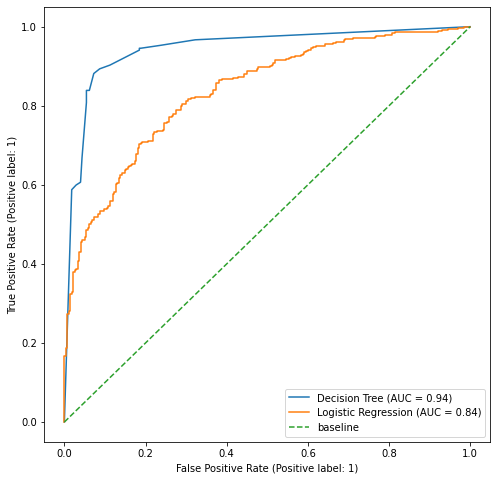

In [29]:
# ROC curve
fig, ax = plt.subplots(figsize=(8,8))

plot_roc_curve(gs_dt, X_test, y_test, ax=ax, name='Decision Tree')
plot_roc_curve(gs_lr, X_test, y_test, ax=ax, name='Logistic Regression')

# add worst case scenario line
plt.plot([0,1],[0,1], label='baseline', linestyle='--')

# add a legend
plt.legend();
# want AUC (area under curve) to be as close to 1 as possible

Interpretation goes here

#### Explore misclassified data

In [160]:
# Get indices of misclassified data
misclass_ind_dt = np.where(y_test != gs_dt_test_preds)
# misclass_ind_dt

In [161]:
X_test_times = df.iloc[X_test.index]['time']

In [162]:
X_test_times.iloc[misclass_ind_dt]

1030    2018-09-15 07:35:30.061576192
999     2018-09-13 12:32:10.061576192
2422    2018-12-04 20:55:30.061576192
2181    2018-11-20 22:12:10.061576192
2477    2018-12-08 01:18:50.061576192
                    ...              
1768    2018-10-28 00:35:30.061576192
2320    2018-11-28 23:15:30.061576192
973     2018-09-12 00:25:30.061576192
1000    2018-09-13 13:55:30.061576192
1009    2018-09-14 02:25:30.061576192
Name: time, Length: 67, dtype: object

In [163]:
pd.DataFrame(X_test_times.iloc[misclass_ind_dt]).reset_index(drop=True)

,time
0,2018-09-15 07:35:30.061576192
1,2018-09-13 12:32:10.061576192
2,2018-12-04 20:55:30.061576192
3,2018-11-20 22:12:10.061576192
4,2018-12-08 01:18:50.061576192
...,...
62,2018-10-28 00:35:30.061576192
63,2018-11-28 23:15:30.061576192
64,2018-09-12 00:25:30.061576192
65,2018-09-13 13:55:30.061576192


In [164]:
frames_dt = [pd.DataFrame(X_test_times.iloc[misclass_ind_dt]), X_test.iloc[misclass_ind_dt], pd.DataFrame(y_test.iloc[misclass_ind_dt])]
misclass_df_dt = pd.concat(frames_dt, axis=1)

In [165]:
misclass_df_dt

,time,10,16,22,28,34,40,46,52,58,...,148,154,160,166,172,178,184,190,196,upwelling
1030,2018-09-15 07:35:30.061576192,15.615140,13.667844,13.078985,12.282153,11.304805,10.805321,10.358133,10.208866,9.925572,...,8.365466,8.307237,8.247876,8.241386,8.136271,8.015464,8.020624,8.012530,7.920358,0
999,2018-09-13 12:32:10.061576192,16.550621,13.822081,12.399839,11.657379,10.670826,10.695434,9.886612,9.865302,9.939895,...,8.062642,7.986984,7.918383,7.814193,7.697048,7.641089,7.563537,7.502224,7.589702,0
2422,2018-12-04 20:55:30.061576192,11.219525,11.193712,11.110235,10.979094,10.498898,10.217004,9.750267,9.683104,9.680013,...,8.610149,8.505400,8.362125,8.308861,8.223542,8.208680,8.199896,8.173240,8.046712,0
2181,2018-11-20 22:12:10.061576192,12.945132,12.608875,12.292109,12.210885,11.219256,10.372250,9.643187,9.710611,9.287130,...,8.519858,8.472281,8.406896,8.333664,8.255387,8.178500,8.126016,8.083357,8.011342,1
2477,2018-12-08 01:18:50.061576192,11.456815,11.426269,11.394139,11.371077,11.063581,11.038057,10.508155,10.225453,10.030742,...,8.805028,8.761912,8.706405,8.665757,8.630679,8.601565,8.577663,8.528271,8.398674,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1768,2018-10-28 00:35:30.061576192,12.238642,11.859039,11.203298,11.146280,10.939370,10.674056,10.378671,10.106237,9.843101,...,8.622281,8.610627,8.594139,8.556967,8.500530,8.507776,8.481923,8.434683,8.387122,0
2320,2018-11-28 23:15:30.061576192,11.616875,12.278866,11.752573,11.388970,10.050966,9.739286,9.653905,9.491666,9.323429,...,8.321613,8.265950,8.183812,8.135732,8.092900,8.042572,8.017640,7.996258,8.006982,0
973,2018-09-12 00:25:30.061576192,16.166946,15.420252,12.608156,10.848536,10.193705,9.883593,9.545262,9.495102,9.445547,...,8.184012,8.032290,7.973088,7.904017,7.847022,7.764610,7.693459,7.659989,7.645759,1
1000,2018-09-13 13:55:30.061576192,15.866948,13.885396,12.766446,12.106518,10.765049,10.210900,9.874925,9.936879,9.923981,...,8.111201,8.039878,7.925470,7.840973,7.739531,7.693048,7.604020,7.536282,7.591148,0


In [166]:
df['CUTI'] = df['CUTI']

df['CUTI']

0       0.978
1       0.978
2       0.978
3       0.978
4       0.978
        ...  
2784    0.171
2785    0.171
2786    0.171
2787    0.171
2788    0.208
Name: CUTI, Length: 2789, dtype: float64